# SNOW Network Extraction

The SNOW algorithm, [published in Physical Review E](https://doi.org/10.1103/PhysRevE.96.023307), uses a marker-based watershed segmentation algorithm to partition an image into regions belonging to each pore.  The main contribution of the SNOW algorithm is to find a suitable set of initial markers in the image so that the watershed is not over-segmented.  SNOW is an acronym for Sub-Network of an Over-segmented Watershed.  PoreSpy includes a predefined function called ``snow`` that applies all the steps automatically, but this example will illustrate the individual steps explicitly on a 3D image.

Start by importing the necessary packages:

In [1]:
import porespy as ps
import matplotlib.pyplot as plt
import imageio
import scipy as sp
import scipy.ndimage as spim
import openpnm as op
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from skimage.morphology import watershed
from porespy.tools import randomize_colors

## Generate Artificial Image

One of the main aims when developing the SNOW algorithm was to extract networks from images other than sandstone, which is the main material studied by geoscientists.  For this demonstration we'll use a high porosity (>85%) image of fibrous media.

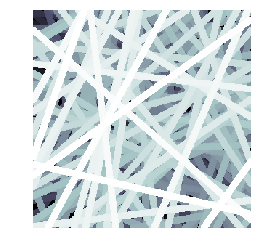

In [2]:
im = ps.generators.cylinders(shape=[300, 300, 300], radius=5, nfibers=200)
plt.imshow(ps.visualization.sem(im), cmap=plt.cm.bone)
plt.axis('off')
plt.show()

## Step-by-Step Application of the SNOW Algorithm

Fist let's find all the peaks of the distance transform which are theoretically suppose to lie at the center of each pore region.  In reality this process finds too many peaks, but we'll deal with this later.

In [3]:
sigma = 0.4
dt = spim.distance_transform_edt(input=im)
dt = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)

The ``gaussian_filter`` is applied to the distance transform before finding the peaks, as this really reduces the number of spurious peaks be blurring the image slightly.  The next few steps use custom made functions to help filter out remaining spurious peaks.  The values of ``sigma`` and ``r`` are both adjustable but the defaults are usually acceptable.

In [4]:
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt, max_iters=500)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)

Initial number of peaks:  943
Peaks after trimming saddle points:  762
Peaks after trimming nearby peaks:  678


The final image processing step is to apply the marker-based ``watershed`` function that is available in **scikit-image** to partition the image into pores.  This function is wrapped by the PoreSpy function ``partition_pore_space``.  ``watershed`` can be called directly, but remember to invert the distance transform so that peaks become valleys (just multiply by -1).  This step is the slowest part of the process by far, but could be sped up if a faster implementation of ``watershed`` is used.  The 300**3 image used in this example will take about 1 minute to complete.

In [5]:
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)

This should produce an image with each voxel labelled according to which pore it belongs.  The patches seem to be a bit odd looking but this is just an artifact of considering a 2D slice through a 3D image.

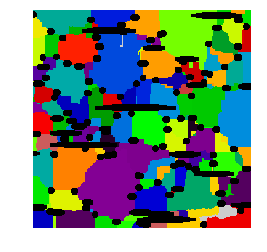

In [6]:
plt.imshow((regions*im)[:, :, 100], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()

Finally, this partitioned image can be passed to the network extraction function which analyzes the image and returns a Python *dict* containing the numerical properties of the network.

In [7]:
net = ps.networks.regions_to_network(im=regions*im, dt=dt, voxel_size=1)

____________________________________________________________
Extracting pore and throat information from image


100%|████████████████████████████████████████████████████████████████████████████████| 678/678 [10:02<00:00,  1.13it/s]


This network can be opened in OpenPNM with ease, and then exported as a VTK file for viewing in ParaView.

In [10]:
pn = op.network.GenericNetwork()
pn.update(net)
prj = pn.project
prj.export_data(filename='extracted_network', filetype='vtk')

In order to overlay both the network and the image in ParaView it is necessary to adjust the image and save it as a vtk image file.

In [13]:
im = ps.tools.align_image_with_openpnm(im).astype(int)
ps.io.to_vtk(im, path='.extracted_network')

![](https://i.imgur.com/JwFRGkW.png)